# The purpose of this notebook is to calculate the Weight of Evidence (WOE) and Information Value (IV) for each predictor variable in our cleaned dataset.

### WOE and IV help us identify which variables have the strongest predictive power in distinguishing good (non-default) vs bad (default) borrowers for our Elder-Care Support Loan credit scorecard.

In [86]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 120)

DATA_PATH = Path("merged_applicant_and_bureau_cleaned.csv")   
OUT_DIR = Path("woe_iv_outputs")                              # local subfolder for outputs
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [87]:
TARGET_COL = "TARGET"   # 0 = good, 1 = bad 

In [88]:
# Load your cleaned dataset
df = pd.read_csv(DATA_PATH)

# Quick checks
print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:20])  # show first 20 columns
df[TARGET_COL].value_counts(dropna=False)
df.head()


Shape: (254358, 28)
Columns: ['SK_ID_CURR', 'TARGET', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AGE', 'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_max', 'CREDIT_DAY_OVERDUE_max', 'CNT_CREDIT_PROLONG_sum', 'CREDIT_ACTIVE_Active']


,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AGE,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO
0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,-1188.0,Core staff,N,N,45.931507,94900.5,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,-225.0,Laborers,Y,Y,52.180822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,-3039.0,Laborers,N,Y,52.068493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,-3038.0,Core staff,N,Y,54.608219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,-1588.0,Laborers,N,Y,46.413699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Function takes in a data frame for a variable with columns: variable values, 'TARGET' values, bin range corresponding to varaible value.

In [89]:
def woe_iv(data):
    working_data = data.copy() 
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace=True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']
    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']
    variable_data['Events'] = working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']
    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']
    
    # Add small constant to avoid division by zero
    variable_data['%_of_Events'] = (variable_data['Events'] + 0.5) / (sum(variable_data['Events']) + 0.5 * len(variable_data))
    variable_data['%_of_Non_Events'] = (variable_data['Non_Events'] + 0.5) / (sum(variable_data['Non_Events']) + 0.5 * len(variable_data))
    
    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])
    variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']
    variable_data['total_IV'] = variable_data['IV'].sum()
    
    return variable_data

# # test the function
# df_bin_data = df.loc[:,('AMT_CREDIT', 'TARGET')].copy()
# df_bin_data['Bin_Range'] = pd.qcut(df['AMT_CREDIT'], q=20)
# woe_iv(df_bin_data)

# Function to calculate WOE, IV and plot IV

In [90]:
# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    variable_data = woe_iv(data)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'bins:', round(variable_data.loc[0,'total_IV'],4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
    
    # Calculate percentages instead of using raw counts
    total_count = variable_data['Count'].sum()
    variable_data['Percent'] = (variable_data['Count'] / total_count) * 100
        
    # plot the bin percentages instead of counts
    sns.barplot(x = variable_data['Bin_Range'], y = variable_data['Percent'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    
    # Update y-axis label to reflect percentage
    ax2.set_ylabel('Percent of Observations (%)')
    
    plt.title("WOE plot for " + variable_name)
    plt.show()
    

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/1750641458.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

IV for AMT_CREDIT with 5 bins: 0.0402


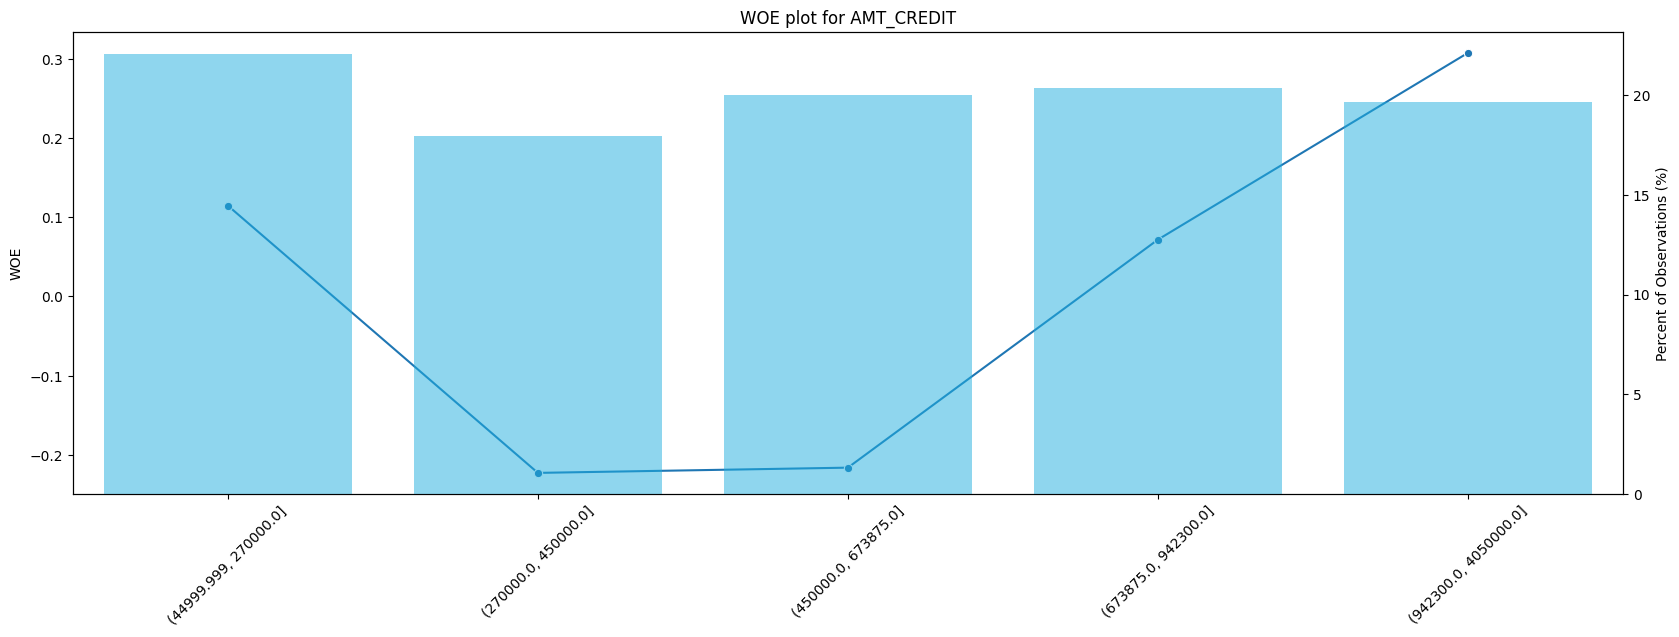

In [91]:
# test the function - create a copy first
variable = 'AMT_CREDIT'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=5)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

# Coarse classing Uses pd.cut to do coarse classing using equal width bins to calcualte IV and plot WOE

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AMT_CREDIT with 6 bins: 0.0272


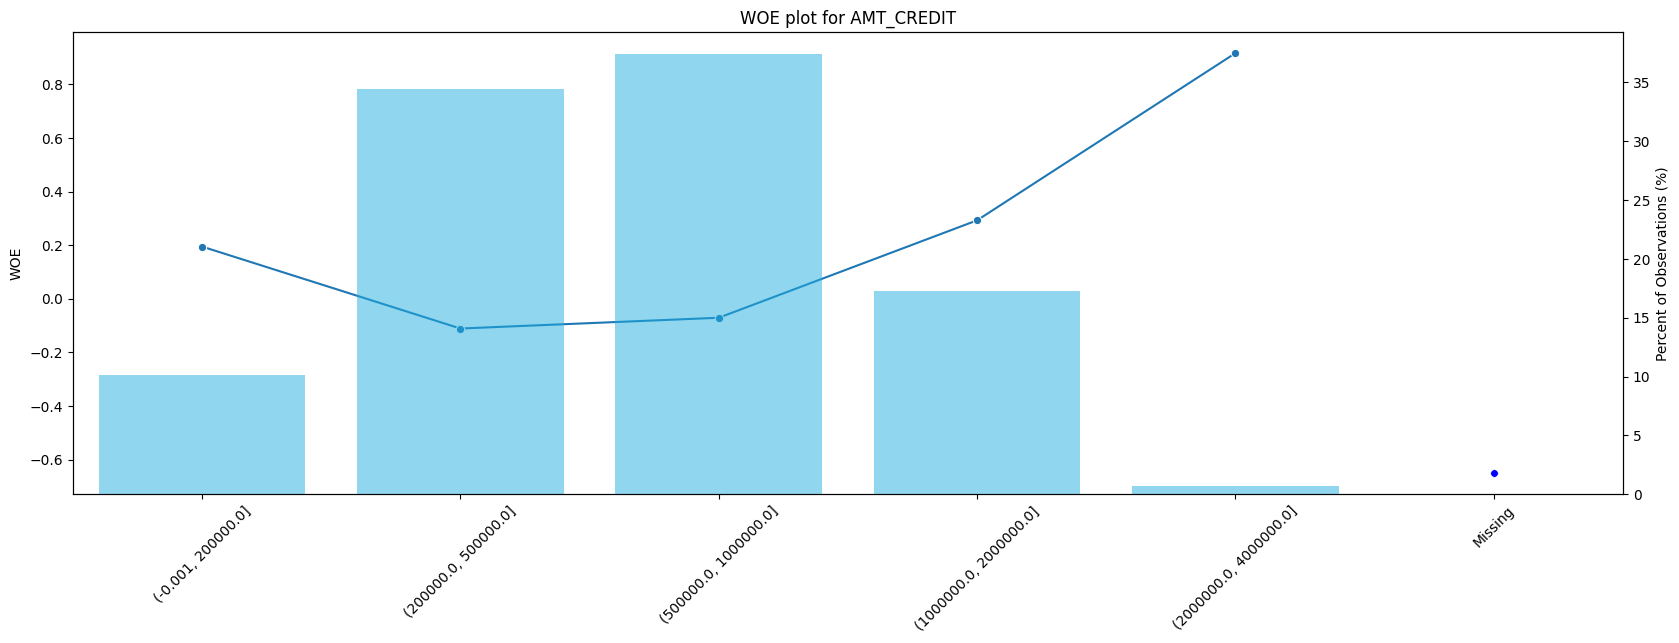

In [92]:
# sample code

bin_edges = [0, 200000, 500000, 1000000, 2000000, 4000000]
variable = 'AMT_CREDIT'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### DAYS_EMPLOYED

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3718830670.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

IV for DAYS_EMPLOYED with 6 bins: 0.0942


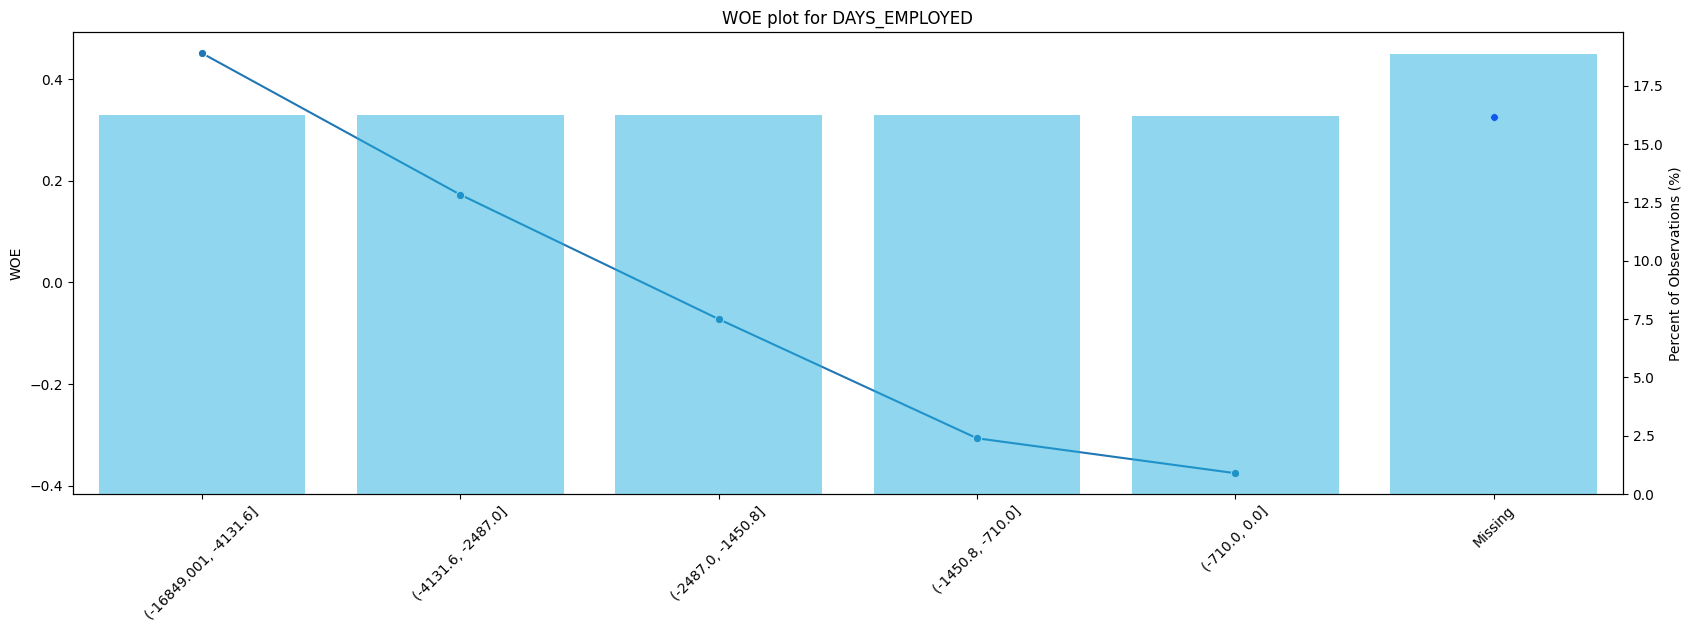

In [93]:
# test the function - create a copy first
variable = 'DAYS_EMPLOYED'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=5)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for DAYS_EMPLOYED with 4 bins: 0.0894


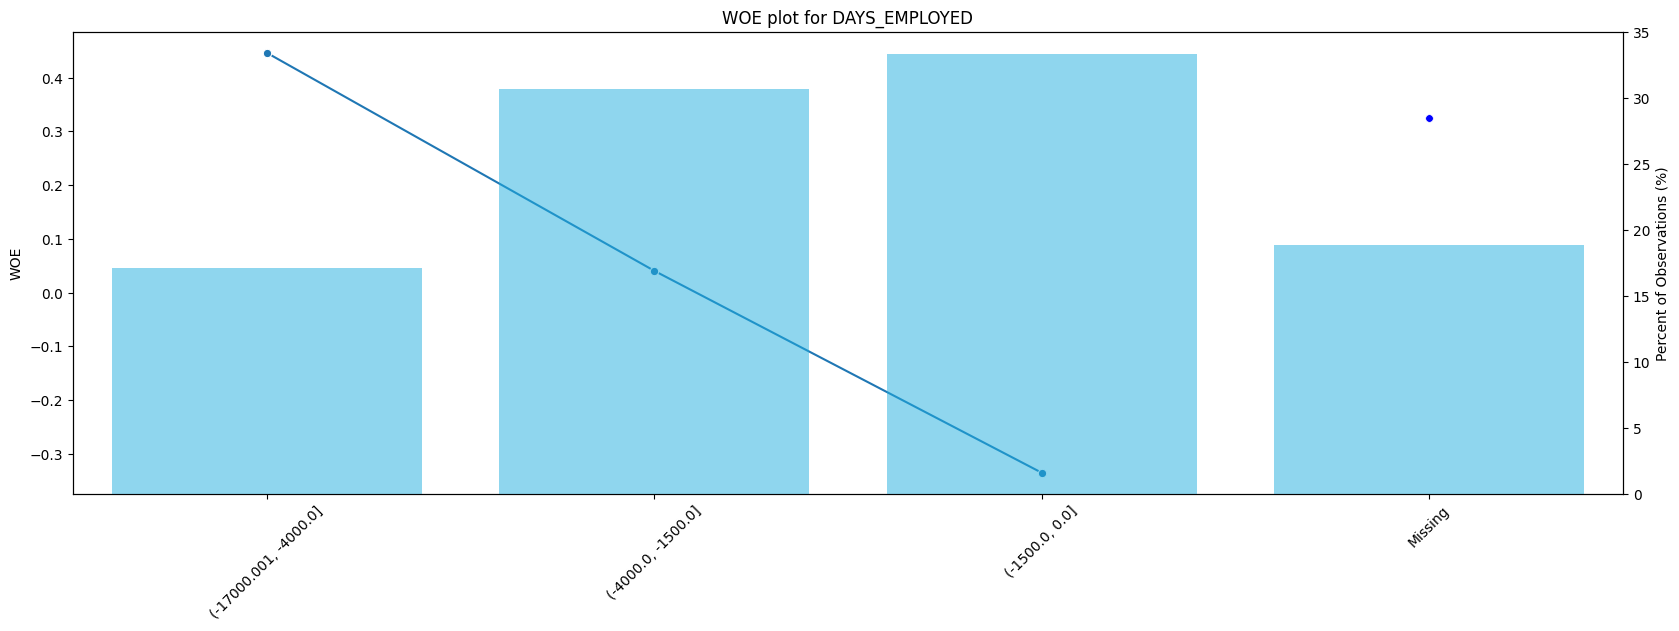

In [94]:
# sample code

bin_edges = [-17000, -4000, -1500, 0]
variable = 'DAYS_EMPLOYED'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### DEBT_RATIO

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/1308165285.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

IV for DEBT_RATIO with 6 bins: 0.0525


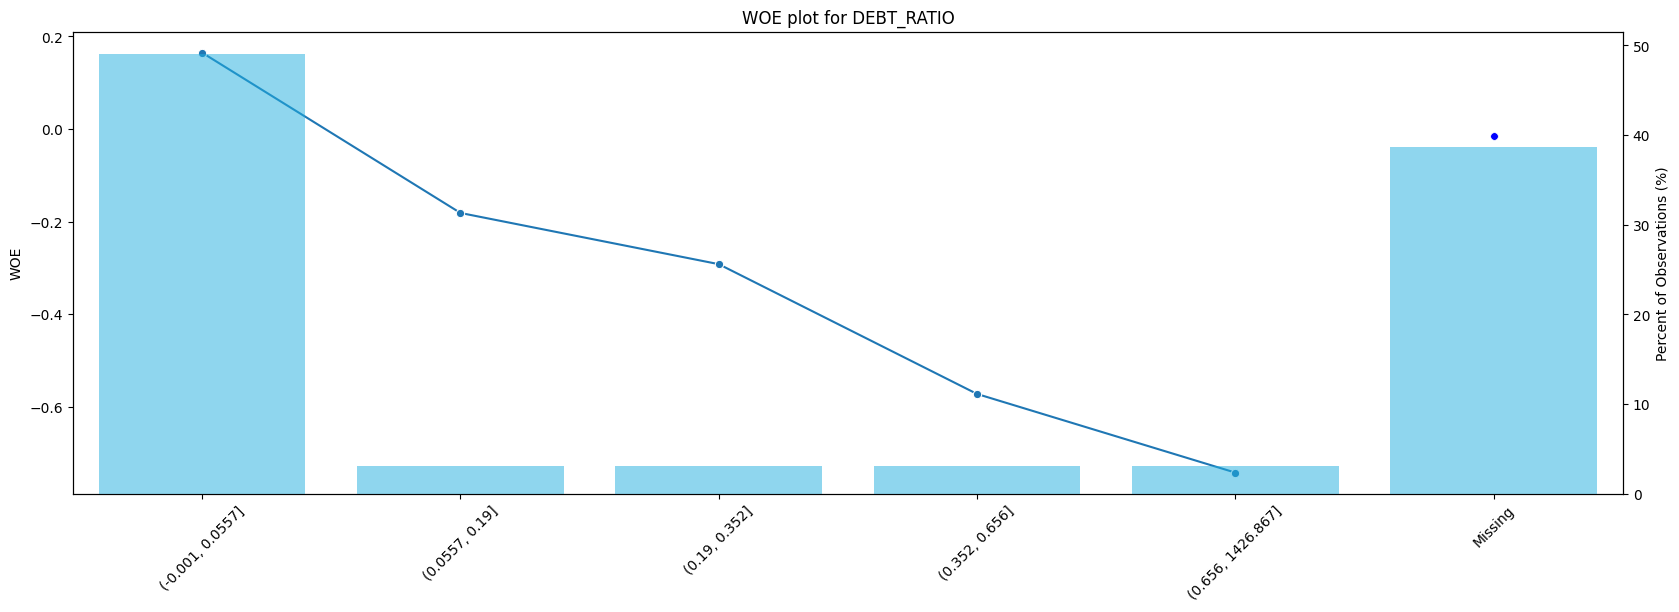

In [100]:
# test the function - create a copy first
variable = 'DEBT_RATIO'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=20, duplicates='drop')
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for DEBT_RATIO with 4 bins: 0.0517


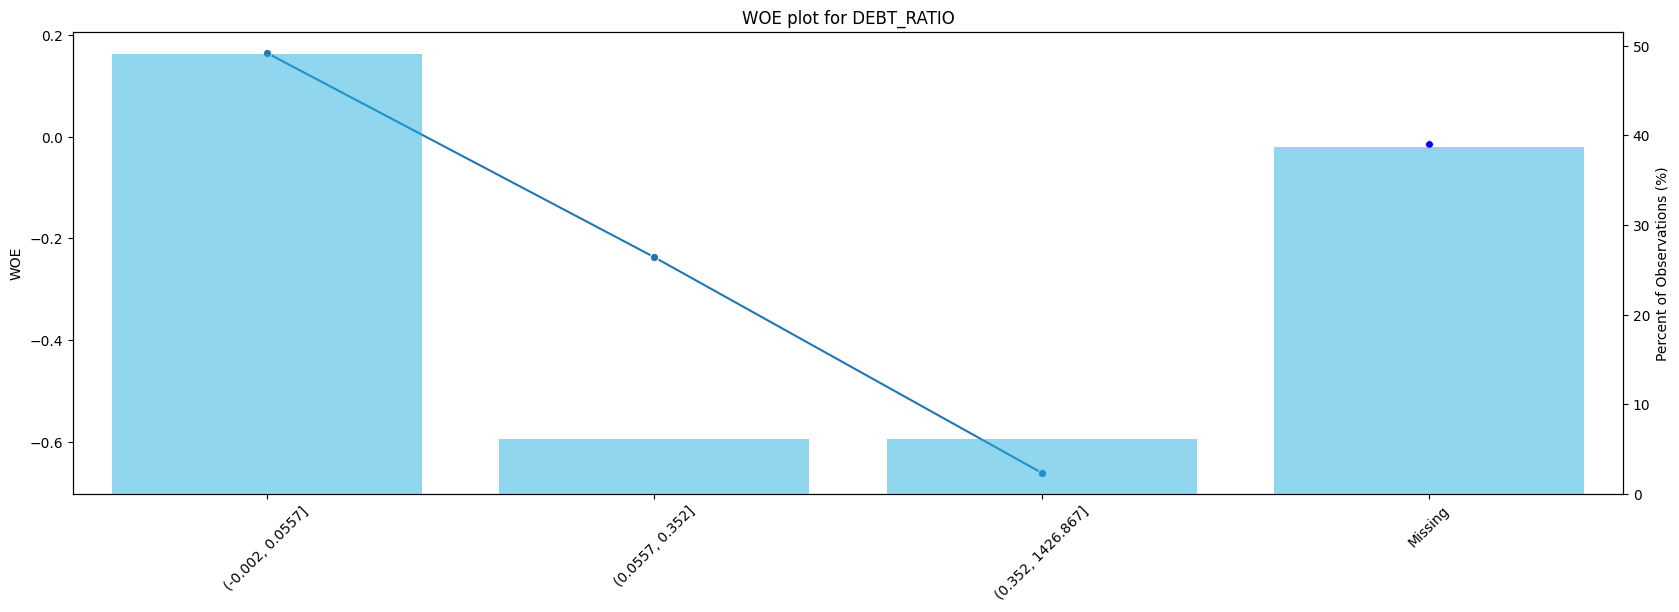

In [102]:
# sample code

bin_edges = [-0.001, 0.0557, 0.352, 1426.867]
variable = 'DEBT_RATIO'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AMT_CREDIT_SUM_DEBT_sum

IV for AMT_CREDIT_SUM_DEBT_sum with 6 bins: 0.0479


/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3052190614.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

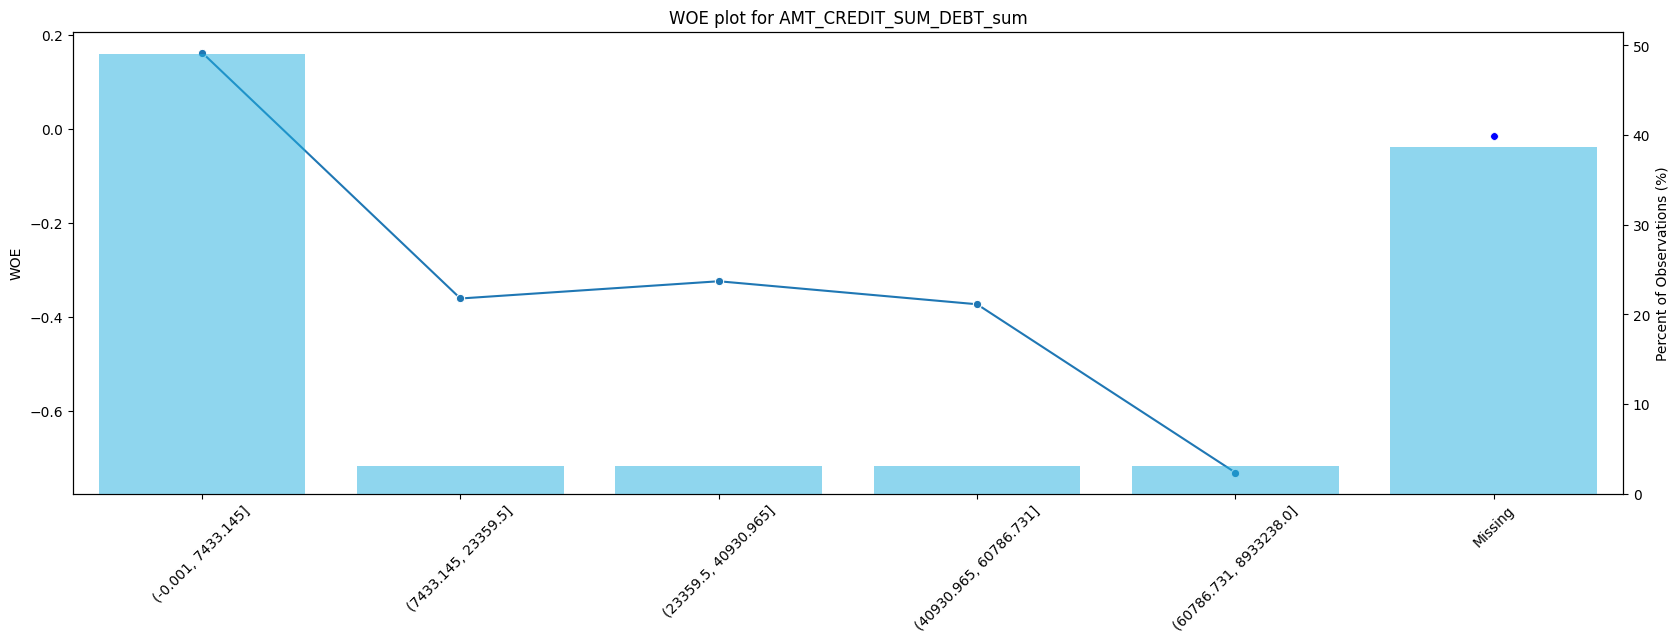

In [53]:
# test the function - create a copy first
variable = 'AMT_CREDIT_SUM_DEBT_sum'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=20, duplicates="drop")
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AMT_CREDIT_SUM_DEBT_sum with 5 bins: 0.0483


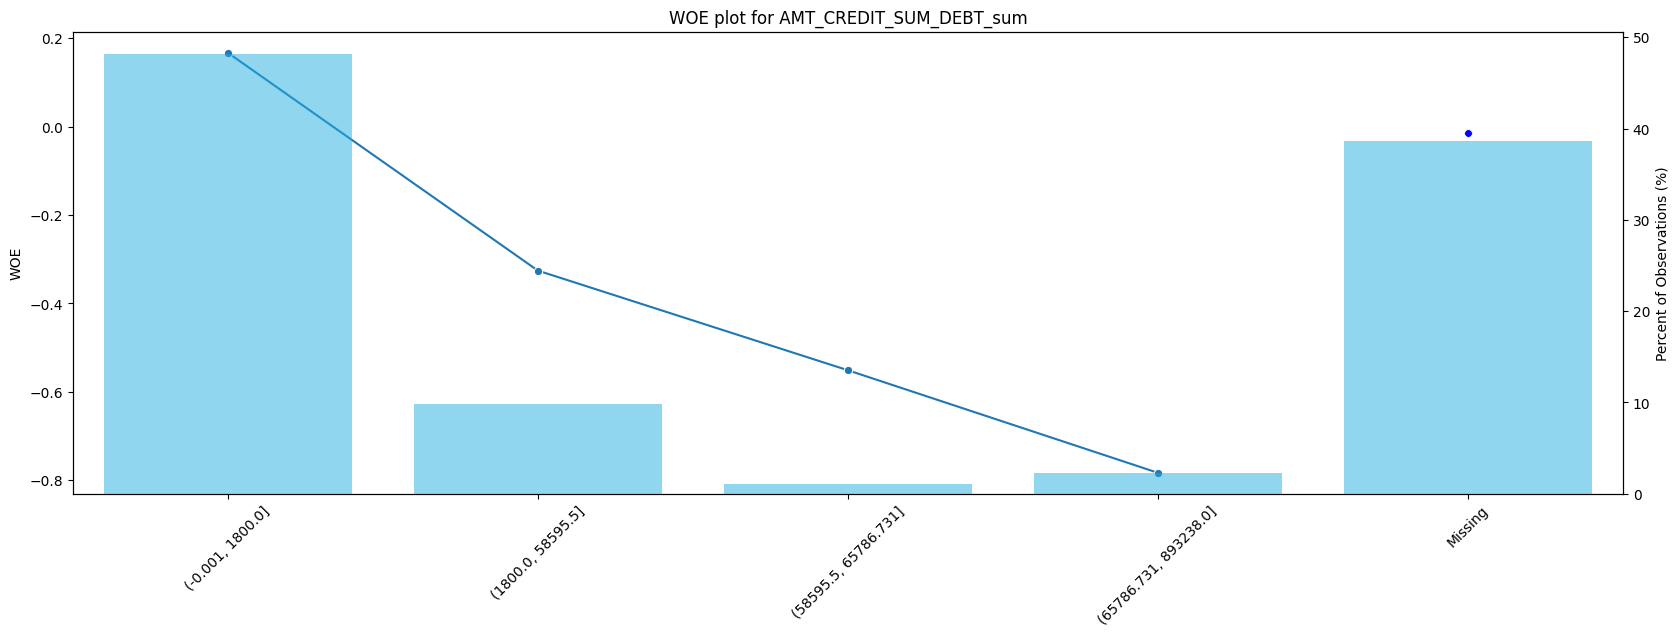

In [66]:
# sample code

bin_edges = [0, 1800, 58595.5, 65786.731, 893238.0]
variable = 'AMT_CREDIT_SUM_DEBT_sum'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AGE

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/2776209989.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

IV for AGE with 6 bins: 0.0539


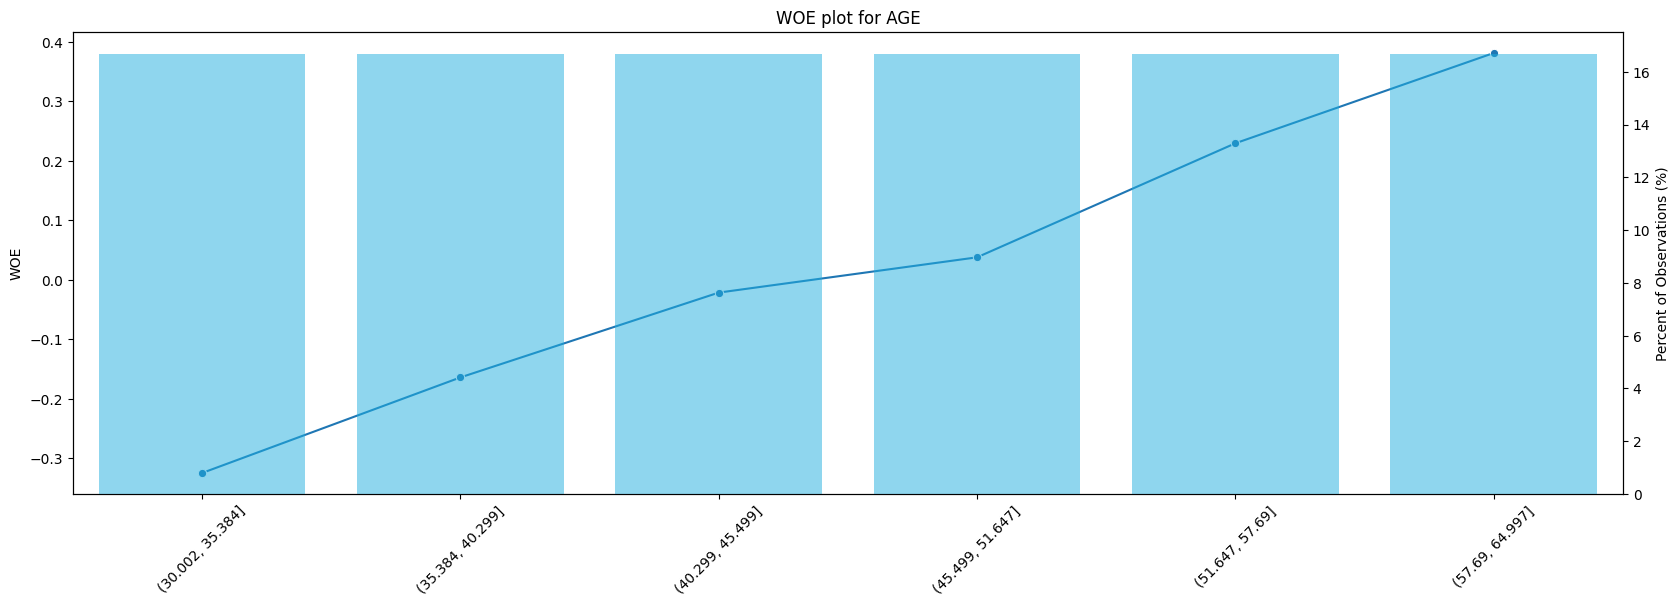

In [103]:
# test the function - create a copy first
variable = 'AGE'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=6)
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for AGE with 4 bins: 0.0499


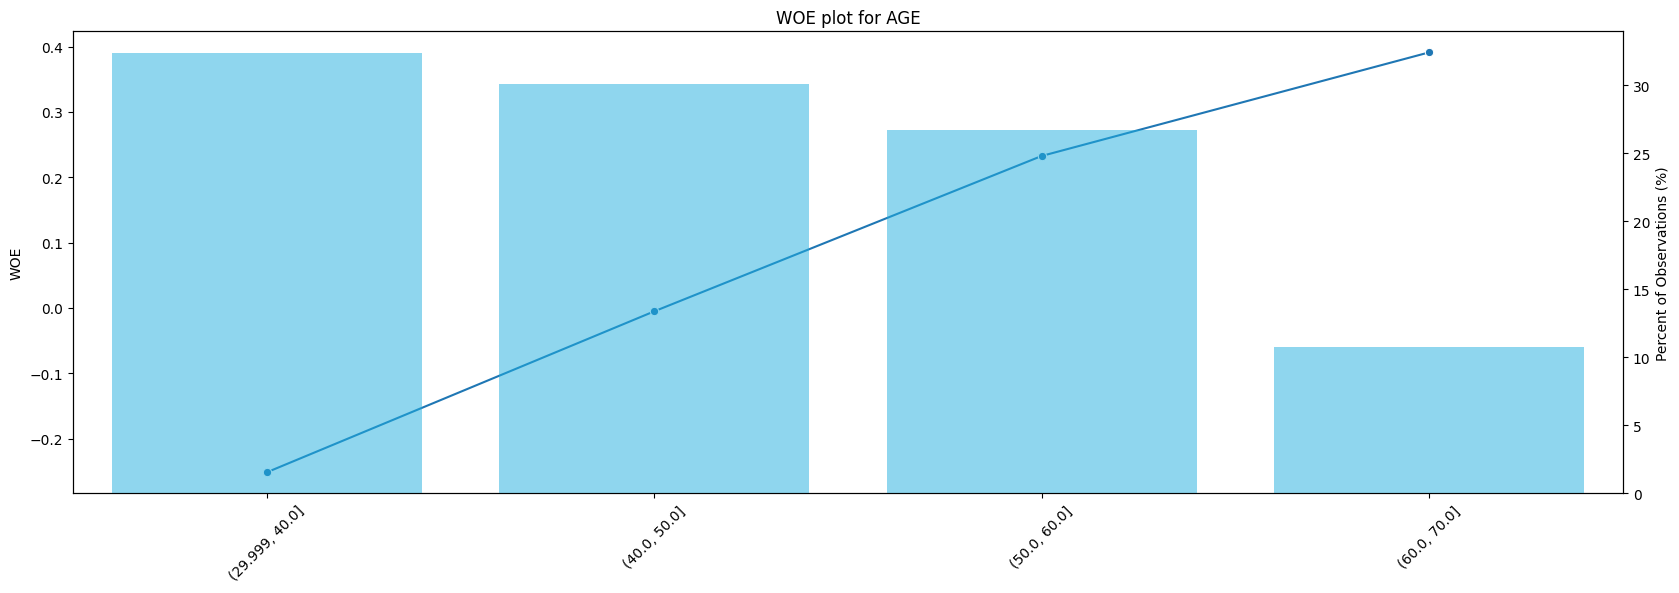

In [104]:
# sample code

bin_edges = [30, 40, 50, 60,  70]
variable = 'AGE'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### CREDIT_ACTIVE_Active

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/446180054.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

IV for CREDIT_ACTIVE_Active with 5 bins: 0.0191


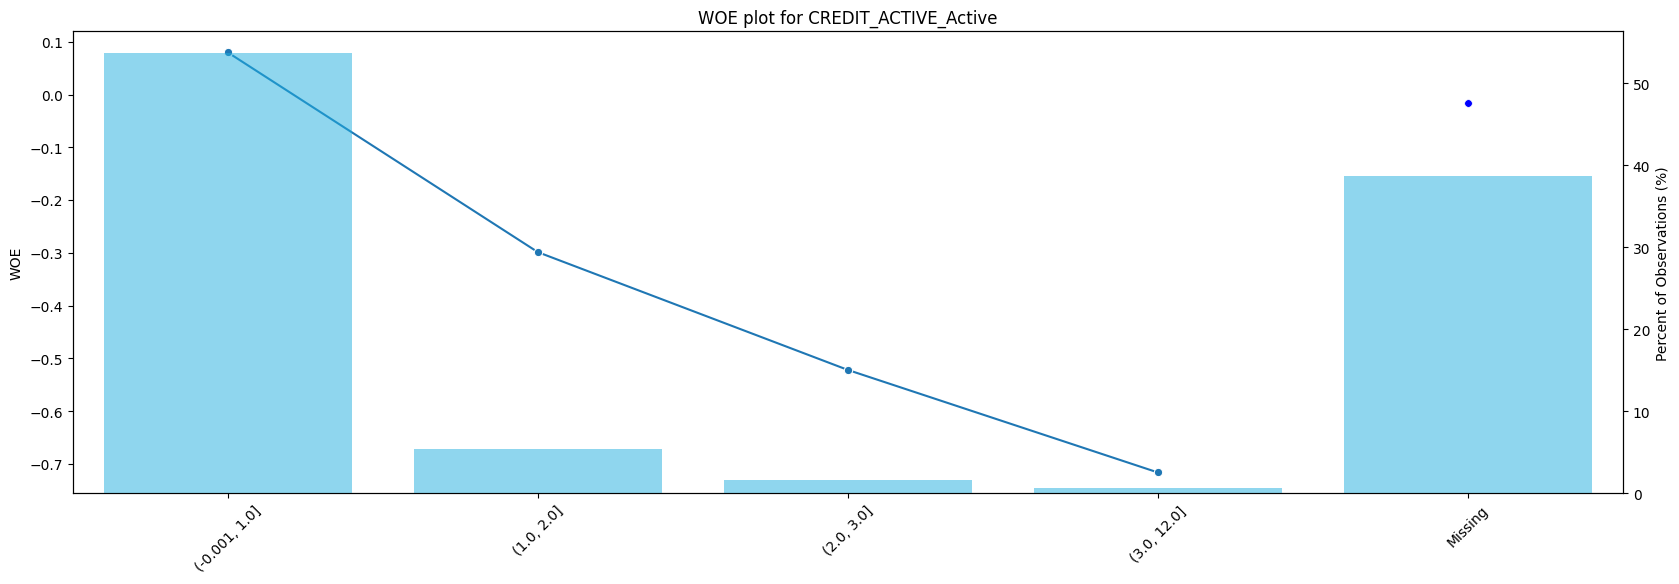

In [105]:
# test the function - create a copy first
variable = 'CREDIT_ACTIVE_Active'
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = pd.qcut(df[variable], q=30, duplicates='drop')
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

/var/folders/69/hc5tv1pn547clcgc4pkpgsp80000gn/T/ipykernel_18170/3375602443.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  working_data['Bin_Range'].fillna('Missing', inplace=True)


IV for CREDIT_ACTIVE_Active with 4 bins: 0.0221


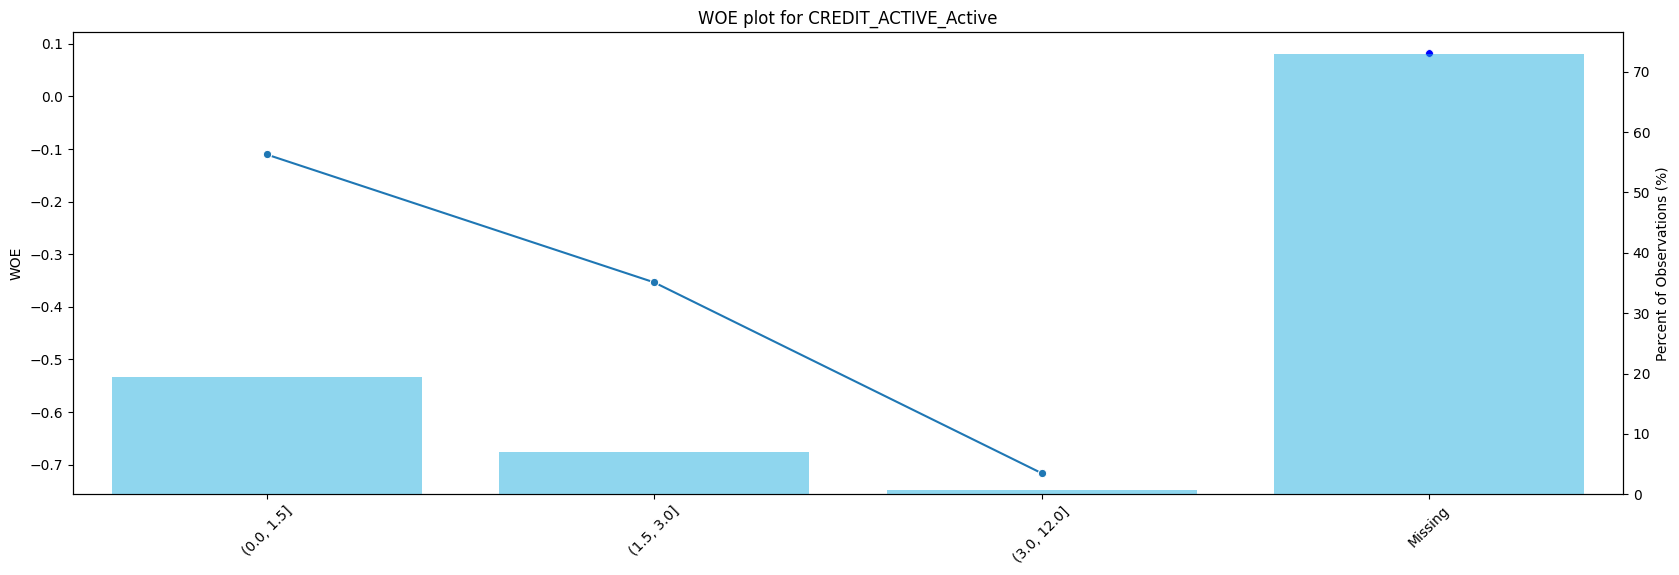

In [108]:
# sample code

bin_edges = [0.001, 1.5, 3.0, 12.0]
variable = 'CREDIT_ACTIVE_Active'

# create groupings based on specified bin edges
df['Bin_Range'] = pd.cut(df[variable], bins = bin_edges, include_lowest= True)
df['Bin_Range'].value_counts().sort_index()

woe_iv_plot(df, variable)


### AMT_GOODS_PRICE	

### AMT_ANNUITY		

### CREDIT_ACTIVE_Closed	

### CREDIT_TYPE_Credit card		

### FLAG_OWN_CAR	

### CREDIT_TYPE_Microloan	

# Categorical
### OCCUPATION_TYPE

C:\Users\johnt\AppData\Local\Temp\ipykernel_28392\1773856854.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_28392\1773856854.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

IV for OCCUPATION_TYPE with 19 categories: 0.0799


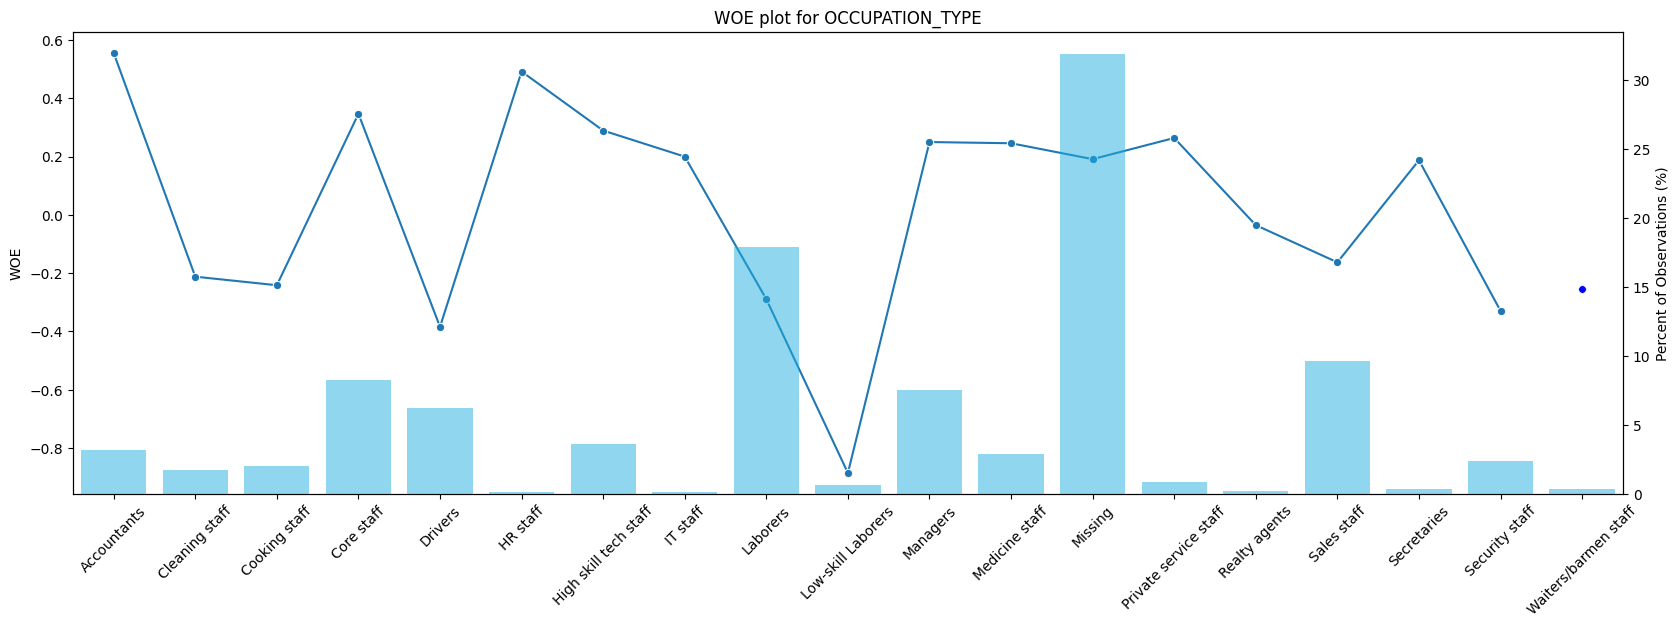

In [12]:
def woe_iv(data):
    working_data = data.copy() 
    working_data['Bin_Range'] = working_data['Bin_Range'].astype('object')
    working_data['Bin_Range'].fillna('Missing', inplace=True)
    
    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby(by='Bin_Range', as_index=False).count()['Bin_Range']
    variable_data['Count'] = working_data.groupby(by='Bin_Range', as_index=False).count()['TARGET']
    variable_data['Events'] = working_data.groupby(by='Bin_Range', as_index=False).sum()['TARGET']
    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']
    
    # Add small constant to avoid division by zero
    variable_data['%_of_Events'] = (variable_data['Events'] + 0.5) / (sum(variable_data['Events']) + 0.5 * len(variable_data))
    variable_data['%_of_Non_Events'] = (variable_data['Non_Events'] + 0.5) / (sum(variable_data['Non_Events']) + 0.5 * len(variable_data))
    
    variable_data['WOE'] = np.log(variable_data['%_of_Non_Events'] / variable_data['%_of_Events'])
    variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']
    variable_data['total_IV'] = variable_data['IV'].sum()
    
    return variable_data


# create IV calc and WOE plotting function
def woe_iv_plot(data, variable_name):
    variable_data = woe_iv(data)
    print('IV for', variable_name, 'with', variable_data.shape[0], 'categories:', round(variable_data.loc[0,'total_IV'],4))
    ffig, ax1 = plt.subplots(figsize=(20,6))

    # if 'missing' bin, do not include in plot
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0:
        sns.lineplot(data = variable_data['WOE'].iloc[0:-1], marker='o', sort = False, ax=ax1)
    else:
        sns.lineplot(data = variable_data['WOE'], marker='o', sort = False, ax=ax1)
    plt.xticks(rotation=45)

    # if 'missing' bin, create the scatter plot to plot the Missing WOE data point
    if variable_data['Bin_Range'].isin(['Missing']).sum() > 0: 
        last_point = len(variable_data['WOE']) - 1
        scatter_plot = sns.scatterplot(x=[last_point], y=[variable_data['WOE'][last_point]], color='b', s=30, ax=ax1)
    
    ax2 = ax1.twinx()
    
    # Calculate percentages instead of using raw counts
    total_count = variable_data['Count'].sum()
    variable_data['Percent'] = (variable_data['Count'] / total_count) * 100
        
    # plot the bin percentages instead of counts
    sns.barplot(x = variable_data['Bin_Range'], y = variable_data['Percent'], alpha=0.5, ax = ax2, color = 'deepskyblue')
    
    # Update y-axis label to reflect percentage
    ax2.set_ylabel('Percent of Observations (%)')
    
    plt.title("WOE plot for " + variable_name)
    plt.show()
    
# test the function for categorical variable
variable = 'OCCUPATION_TYPE'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

### NAME_INCOME_TYPE

C:\Users\johnt\AppData\Local\Temp\ipykernel_28392\590647377.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_28392\1773856854.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


IV for NAME_INCOME_TYPE with 8 categories: 0.0467


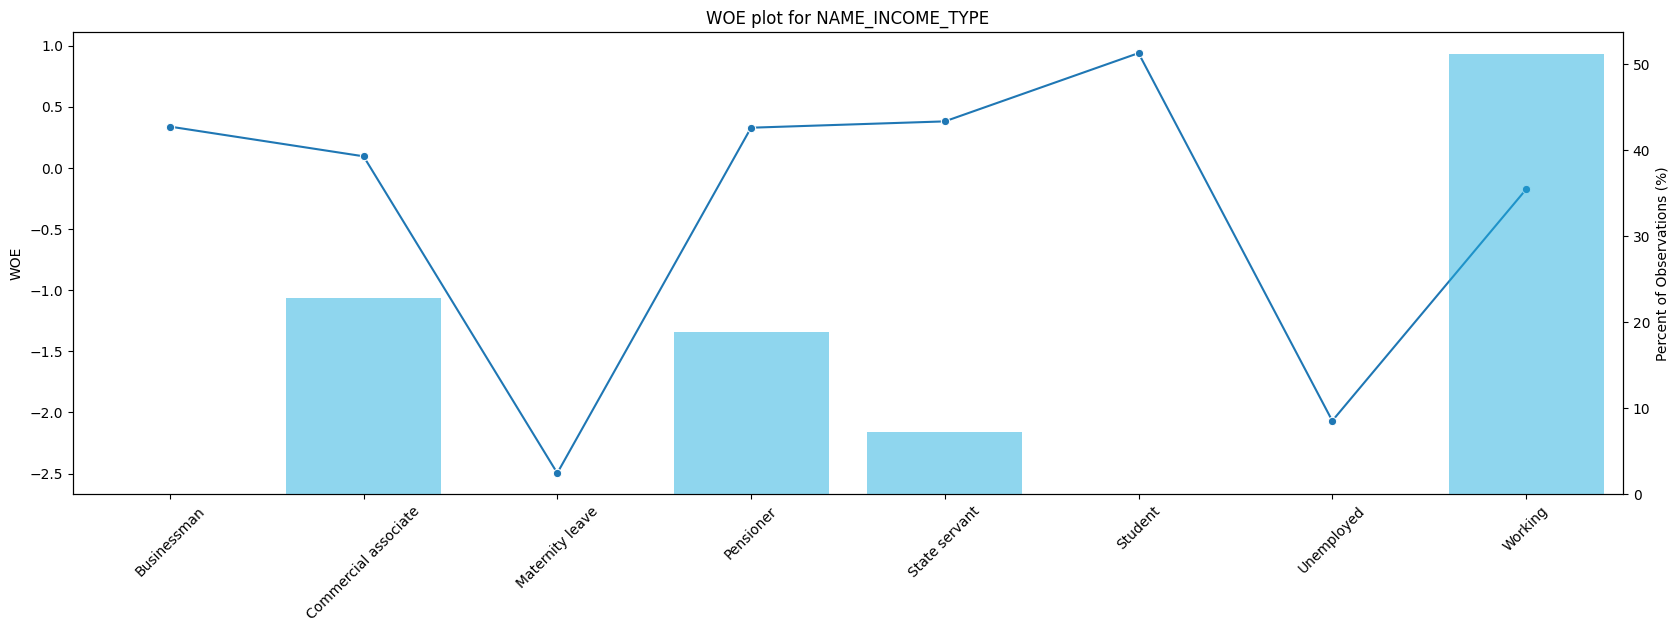

In [13]:
# test the function for categorical variable
variable = 'NAME_INCOME_TYPE'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

### NAME_FAMILY_STATUS

C:\Users\johnt\AppData\Local\Temp\ipykernel_28392\1802753599.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
C:\Users\johnt\AppData\Local\Temp\ipykernel_28392\1773856854.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

IV for NAME_FAMILY_STATUS with 6 categories: 0.0156


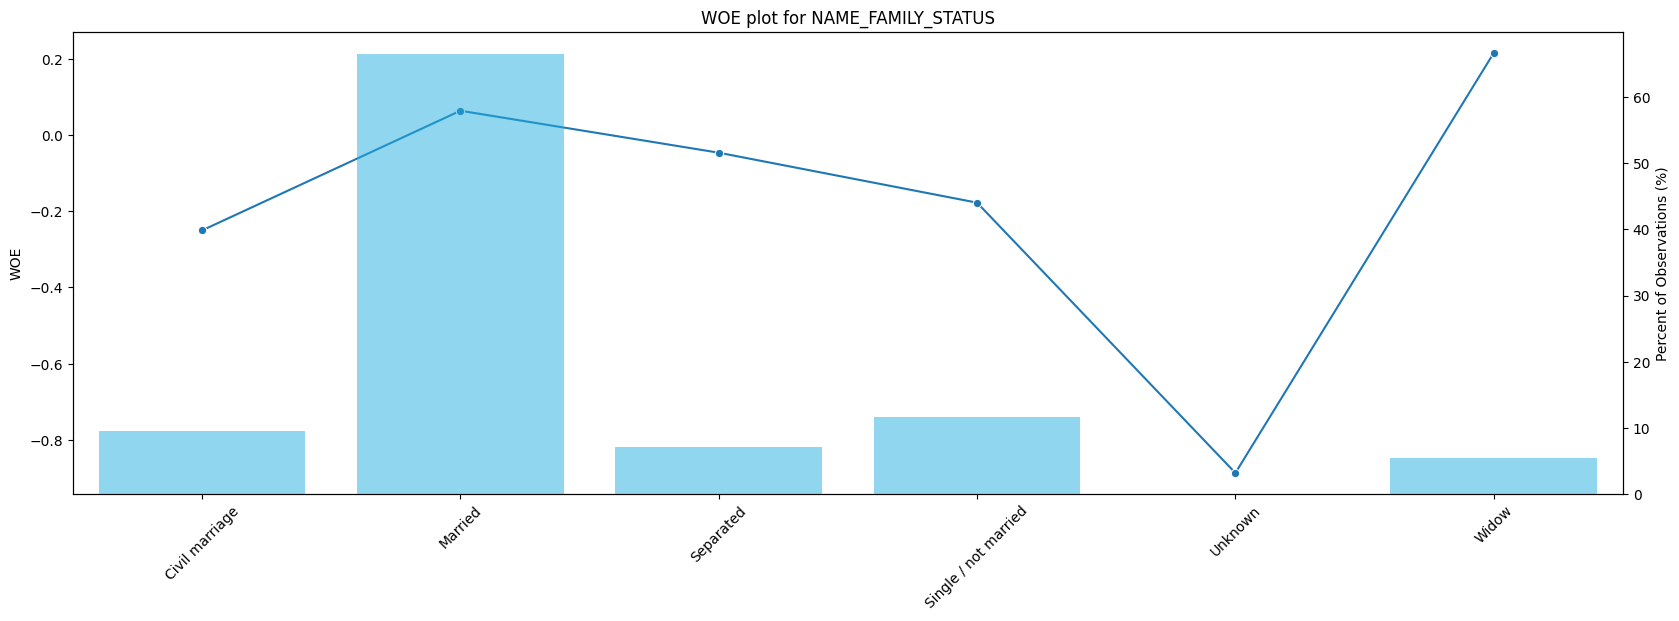

In [14]:
# test the function for categorical variable
variable = 'NAME_FAMILY_STATUS'  # Example categorical variable
woe_bin_data = df.loc[:,(variable, 'TARGET')].copy()
woe_bin_data['Bin_Range'] = woe_bin_data[variable]  # Use categorical values directly instead of binning
woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype('object')
woe_bin_data['Bin_Range'].fillna('Missing', inplace=True)
woe_iv_plot(woe_bin_data, variable)

In [ ]:
df

,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,OCCUPATION_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AGE,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_OVERDUE_max,CREDIT_DAY_OVERDUE_max,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO,Bin_Range
0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,-1188.0,Core staff,N,N,45.931507,94900.5,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-1500.0, 0.0]"
1,100004,0,Working,Single / not married,0,67500.0,135000.0,6750.0,135000.0,-225.0,Laborers,Y,Y,52.180822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-1500.0, 0.0]"
2,100006,0,Working,Civil marriage,0,135000.0,312682.5,29686.5,297000.0,-3039.0,Laborers,N,Y,52.068493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-4000.0, -1500.0]"
3,100007,0,Working,Single / not married,0,121500.0,513000.0,21865.5,513000.0,-3038.0,Core staff,N,Y,54.608219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-4000.0, -1500.0]"
4,100008,0,State servant,Married,0,99000.0,490495.5,27517.5,454500.0,-1588.0,Laborers,N,Y,46.413699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-4000.0, -1500.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254353,456248,0,Working,Separated,0,153000.0,331920.0,16096.5,225000.0,-7258.0,Sales staff,N,Y,45.767123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-17000.001, -4000.0]"
254354,456252,0,Pensioner,Widow,0,72000.0,269550.0,12001.5,225000.0,NaN,NaN,N,Y,56.917808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254355,456253,0,Working,Separated,0,153000.0,677664.0,29979.0,585000.0,-7921.0,Managers,N,Y,41.002740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(-17000.001, -4000.0]"
254356,456254,1,Commercial associate,Married,0,171000.0,370107.0,20205.0,319500.0,-4786.0,Laborers,N,Y,32.769863,45000.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"(-17000.001, -4000.0]"


: 